<a href="https://colab.research.google.com/github/fqixiang/workshop_llm_data_collection/blob/main/llm_regression_modelling_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Large Language Models for Regression Modelling in Social Sciences

In this tutorial, we look at the following regression model:

`performace ~ 1 + specificity`

That is, we regress student performances on specificity scores.

First, we're going to simulate some data for performance and specificity. With this simulated dataset, we can investigate how measurement error affects regression results.

Second, we're going to learn how to correct for measurement error with Gabrielle Martins van Jaarsveld's SoDa fellowship dataset.

In [ ]:
# Install required packages
%pip install ppi-python

## Influence of measurement error in regression modelling



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ppi_py import ppi_ols_pointestimate, ppi_ols_ci
import statsmodels.api as sm
import seaborn as sns

Let's simulate some data.

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Simulate true X (specificity) and Y (performance)
n = 100
x_true = np.random.choice([0, 1, 2], n)
beta = 0.5  # True regression coefficient
intercept = 0
y = intercept + beta * x_true + np.random.normal(0, 0.1, n)  # Adding noise to y

Introduce systematic and random error into the predictor x.

In [ ]:
# Introduce measurement errors
systematic_error = 1  # Systematic shift in x
random_error = np.random.normal(0, 1, n)  # Random error

x_systematic = x_true + systematic_error  # X with systematic measurement error
x_random = np.round(x_true + random_error)  # X with random measurement error
x_random = [0 if score < 0 else score for score in x_random]
x_random = [2 if score > 2 else score for score in x_random]

#### Influence of systematic error in regression modelling

In [ ]:
# Function to fit and plot regression
def plot_regression(x:list, y:list, label:str, ax, x_ticks:list):
    x_const = sm.add_constant(x)  # Add intercept
    model = sm.OLS(y, x_const).fit()

    # Scatter plot with regression line
    sns.regplot(x=x, y=y, ci=95, ax=ax, scatter_kws={"s": 20}, label=label)

    # Display slope
    ax.set_title(f"{label}\nEstimated β = {model.params[1]:.2f}")
    # Set x-axis ticks to only 0, 1, and 2
    ax.set_xticks(x_ticks)

    # Labels and title
    ax.set_xlabel("X: Specificity")
    ax.set_ylabel("Y: Performance")

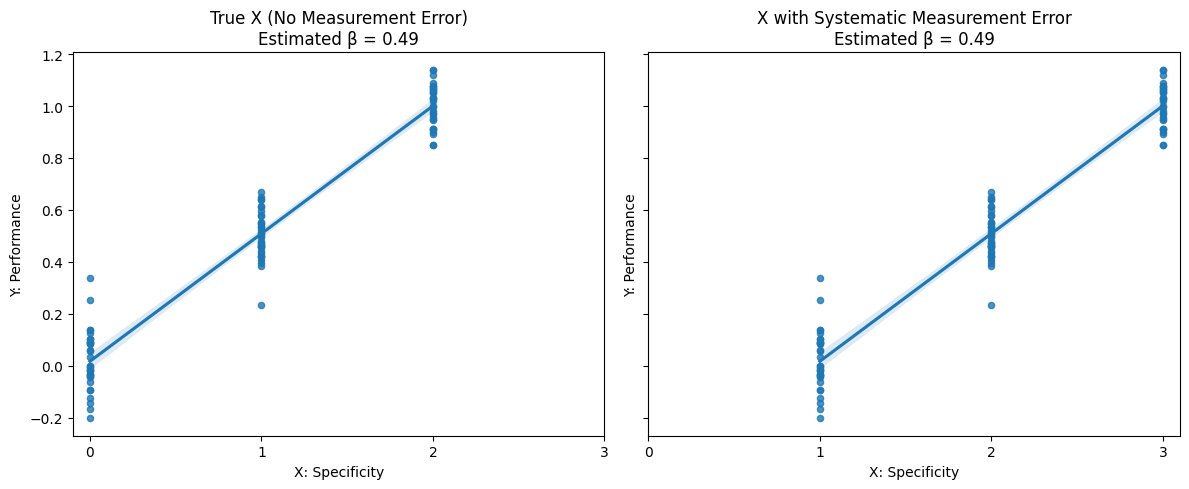

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot original (true X)
plot_regression(x_true, y, "True X (No Measurement Error)", axes[0], [0,1,2,3])

# Plot X with systematic measurement error
plot_regression(x_systematic, y, "X with Systematic Measurement Error", axes[1], [0,1,2,3])

# Display
plt.tight_layout()
plt.show()

#### Influence of random error in regression modelling

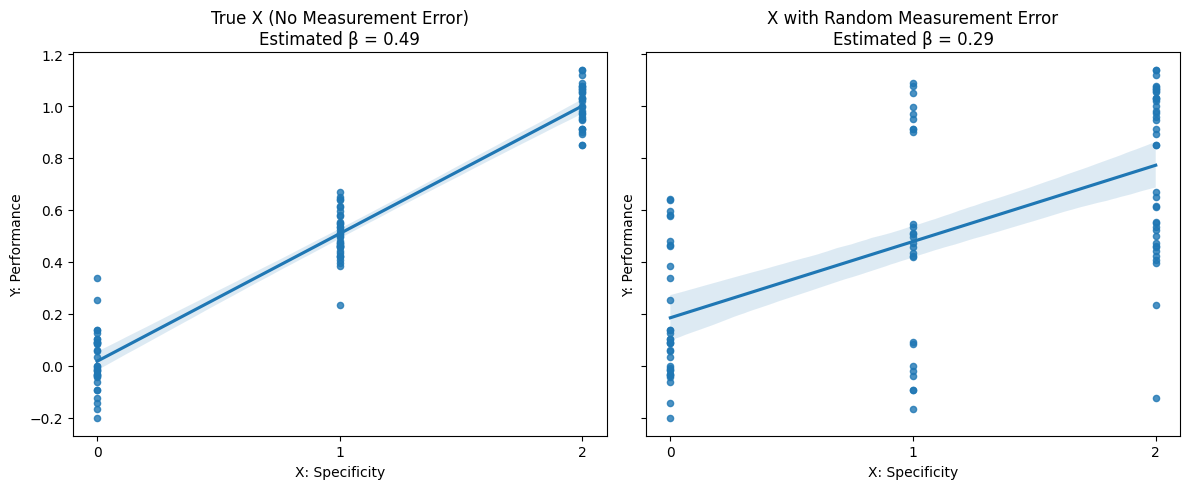

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot original (true X)
plot_regression(x_true, y, "True X (No Measurement Error)", axes[0], [0,1,2])

# Plot X with random measurement error
plot_regression(x_random, y, "X with Random Measurement Error", axes[1], [0,1,2])

# Display
plt.tight_layout()
plt.show()

## Correcting measurement error in regression with the ppi_py package

Now that we have seen how measurement errror can affect statistical modelling, let's try to correct for it!

We will use the same toy dataset as in the previous tutorial, which comes from Gabrielle Martins van Jaarsveld's SoDa fellowship project on annotating markers of self-regulated learning from student conversation data. Feel free to use your own data.

For Python users, the `ppi_py` package comes in handy for this purpose. Note that `ppi_py` can only handle measurement error in the outcome variable of a regression model. Unfortunately, there is no existing Python package that can handle measurement error in predictors of regression model (or both predictors and outcomes). In R, however, you find several good alternatives. See below or check out https://github.com/sodascience/social_science_inferences_with_llms

### Software Packages
| Name | Method | Language | Estimators | Predicted Variables |
|----|----|----|----|----|
| [PostPI](https://github.com/leekgroup/postpi) | Post-Prediction Inference | R | Means, quantitles and GLMs | Outcome |
| [PPI, PPI++, Cross-PPI, PPBoot](https://github.com/aangelopoulos/ppi_py) | Prediction-powered inference and its extensions | Python | Any arbitrary estimator | Outcome |
| [PSPA](https://github.com/qlu-lab/pspa) | PoSt-Prediction Adaptive inference | R | Means, quantiles, linear regression, logistic regression | Predictor and outcome |
| [ipd](https://github.com/ipd-tools/ipd) | Implemented PostPI, PPI, PPI++ and PSPA | R | Means, quantiles, linear regression, logistic regression | Outcome |
| [PSPS](https://github.com/qlu-lab/psps) | PoSt-Prediction Summary-statistics-based (PSPS) inference | R and Python | M-estimators | Outcome |
| [DSL](https://naokiegami.com/dsl/) | Design-based Supervised Learning | R | Moment-based estimators | Predictor and outcome |


### Data loading

In [ ]:
# Google Sheets export link
sheet_url = "https://docs.google.com/spreadsheets/d/1yLKp2HYW2gPlJv1kyqjjr1qLtOA-O5pPGttAMX5wvbY/export?format=csv"

# Read CSV into DataFrame
df = pd.read_csv(sheet_url)

### Build a gold dataset and regression

First, let's build a subset of Gabrielle's dataset that contains only gold labels (i.e., error-free measurements).

In [ ]:
# We keep the subset where there is no missing value for both the
# "score_specificity_human" and "performance" columns.
df_gold = df.dropna(subset=["score_specificity_human", "performance"],
                    ignore_index=True)
# We expand this dataset by 5 fold; otherwise the sample size is too small.
df_gold = pd.concat([df_gold]*5)

# A handy function to fit a regression model and print model summary.
def run_lm(x:list, y:list):
    X = sm.add_constant(x)
    lm_results = sm.OLS(y, X).fit()
    print(lm_results.summary())

x_gold = df_gold['score_specificity_human'].tolist()
y_gold = df_gold['performance'].tolist()

# Fit linear regression model
run_lm(x_gold, y_gold)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     5.791
Date:                Thu, 20 Mar 2025   Prob (F-statistic):             0.0174
Time:                        19:50:44   Log-Likelihood:                -220.68
No. Observations:                 145   AIC:                             445.4
Df Residuals:                     143   BIC:                             451.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4908      0.156     41.571      0.0

We know now that for these observations, the gold regression coefficient is 0.337 with a confidence interval of [0.060, 0.614] and statistical significance at 0.05 alpha level.

Because the ppi_py package only corrects for measurement error in the outcome variable of the regression model (instead of the predictor variable), let's pretend that:

1. The specificity measurements (i.e., the predictor) are completely observed and error free;
2. In contrast, the performance measurements (i.e., the outcome variable) are only partially observed (i.e., we only have partial labels) and for the unobserved y values, we have their corresponding predictions (y_hat), which can come from LLMs and likely suffer from measurement error. To simplify our analysis, we will manually make these predictions instead of using LLMs.

### Create performance predictions and data partitions

Let's create a predicted performance variable (`performance_pred`) by introducing measurement error into the original `performance` variable.

In [ ]:
bias = 1
np.random.seed(42)
df_gold["performance_pred"] = df_gold["performance"] - bias + np.random.normal(0, 0.5, df_gold.shape[0])

We shuffle the dataset and split it into two partitions: `df_observed` where we have both error-free measurements and predictions, and `df_unobserved` where we have only predictions.

In [ ]:
df_gold_shuffled = df_gold.sample(frac=1, random_state=42, axis=0, ignore_index=True)

p_unobserved_y = 0.5
n_unobserved_y = int(p_unobserved_y * df_gold_shuffled.shape[0])
df_observed = df_gold_shuffled.iloc[:-n_unobserved_y,:]
df_unobserved = df_gold_shuffled.iloc[-n_unobserved_y:,:]

### Regression model with observed partition

What happens if we run a regression model on the observed partition? That is, we ignore all the prediction-based data.

In [ ]:
run_lm(df_observed['score_specificity_human'].tolist(),
       df_observed['performance'].tolist())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.438
Date:                Thu, 20 Mar 2025   Prob (F-statistic):             0.0679
Time:                        19:51:02   Log-Likelihood:                -103.42
No. Observations:                  73   AIC:                             210.8
Df Residuals:                      71   BIC:                             215.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6203      0.179     37.042      0.0

You can see that the regression coefficient is estimated to be 0.307, much smaller than the gold value 0.337 and is no longer statistically significant at 0.05 alpha level. The confidence interval also now contains zero.

### Corrected regression model on all data using ppi_py

To use the `ppi_py` package to correct our regression estimates, we need to prepare the following variables:

- `X` (ndarray): Covariates corresponding to the gold-standard labels.
- `Y` (ndarray): Gold-standard labels.
- `Yhat` (ndarray): Predictions corresponding to the gold-standard labels.
- `X_unlabeled` (ndarray): Covariates corresponding to the unlabeled data.
- `Yhat_unlabeled` (ndarray): Predictions corresponding to the unlabeled data.

In [ ]:
df_observed["intercept"] = 1
df_unobserved["intercept"] = 1

X = np.array(df_observed[["intercept", 'score_specificity_human']])
Y = np.array(df_observed['performance'])
Yhat = np.array(df_observed['performance_pred'])
X_unlabeled = np.array(df_unobserved[["intercept", 'score_specificity_human']])
Yhat_unlabeled = np.array(df_unobserved['performance_pred'])

Use the `ppi_ols_pointestimate` function from the `ppi_py` package to obtain measurement error-corrected regression estimates.

In [ ]:
ppi_pointestimate = ppi_ols_pointestimate(X=X,
                                          Y=Y,
                                          Yhat=Yhat,
                                          X_unlabeled=X_unlabeled,
                                          Yhat_unlabeled=Yhat_unlabeled)
print("Corrected point estimate:", ppi_pointestimate[1])

Corrected point estimate: 0.3462655476497703


We can see that the corrected regression estimate (0.346) is closer than the uncorrected one (0.307) to the true value (0.337).

Now let's calcualte the corrected confidence interval.

In [ ]:
ppi_ci = ppi_ols_ci(X=X,
                    Y=Y,
                    Yhat=Yhat,
                    X_unlabeled=X_unlabeled,
                    Yhat_unlabeled=Yhat_unlabeled)
print("Corrected confidence interval:", [subarr[1] for subarr in ppi_ci])

Corrected confidence interval: [np.float64(0.058038350847231523), np.float64(0.6315929841091867)]


We can also see that the confidence interval no longer contains zero, which also indicates likely statistical significance at 0.05 alpha level.

### Exercise: Try your own data!

In [ ]:
# Let's write some code!